# Introduction to Natural Language Processing - CT5146 Assignment 2
## Daniel Verdejo - 22240224



### Task 1a

Plot a group bar plot to show the distribution of sentiment classes (positive, negative, neutral) in the train and dev dataset.


In order to manage the data and visualize it the Pandas and Matplotlib libraries will be used. The reasoning behind using these libraries is obvious.

**Pandas** is a powerful library for data management due to its easy-to-use functions that facilitate the consumption of data from various file types, including .csv. Furthermore, it offers the DataFrame data structure, which is ideal for tabular data such as comma-separated values, simplifying manipulation and analysis.

**Matplotlib** offers many diffrent plots from bars, pies, scatter, line and more, making it an obvious choice to visualize many sorts of data in different ways. The visualization is highly configurable allowing control of aspects such as axis, colours, labels, and titles. 

Both of these libraries have strong integrations meaning a seamless dataflow from data ingestion to visualization and data analysis. As well as this the libraries are commonplace in most data science projects and as such work well with many other libraries such as numpy, scikit-learn and more meaning less time wasted trying to get libraries to work with one another.

In [1]:
!pip install spacy pandas matplotlib nltk sklearn gensim keras numpy joblib


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

nltk.download('treebank')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordDetokenizer, TreebankWordTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from joblib import parallel_backend

import gensim.downloader as api


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


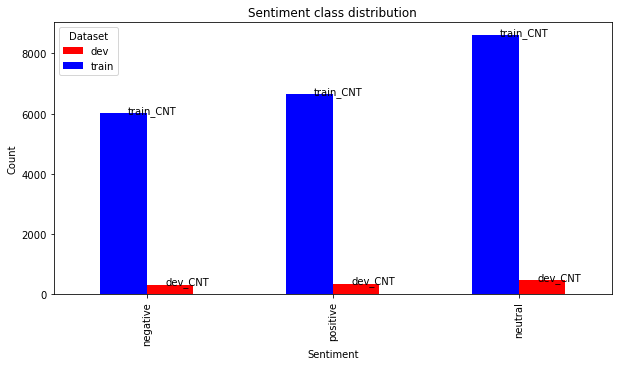

In [3]:
train_df = pd.read_csv('./data/train.csv')
dev_df = pd.read_csv('./data/dev.csv')
test_df = pd.read_csv('./data/test.csv')
train_sentiment_cnts = train_df['sentiment'].value_counts()
dev_sentiment_cnts = dev_df['sentiment'].value_counts()

order = ['negative', 'positive', 'neutral']
fig, ax = plt.subplots(figsize=(10, 5))

dev_sentiment_cnts.reindex(order).plot(kind='bar', ax=ax, position=0, color='red', width=0.25, label='dev')
for i, (_, v) in enumerate(zip(order, dev_sentiment_cnts.reindex(order))):
    ax.text(i+0.1, v, 'dev_CNT')

train_sentiment_cnts.reindex(order).plot(kind='bar', ax=ax, position=1, color='blue', width=0.25, label='train')
for i, (_, v) in enumerate(zip(order, train_sentiment_cnts.reindex(order))):
    ax.text(i-0.1,  v, 'train_CNT')

ax.set_title('Sentiment class distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.legend(title='Dataset', loc='upper left')
ax.set_xlim(-0.5, len(order) -0.5)

plt.show()

Now that we have consumed our data and visualised it we can see what we are working with.

## Task 2a

First some utility functions to clean / preprocess the data

In [4]:
punc = list(string.punctuation)
tknz = TreebankWordTokenizer()
detokenizer = TreebankWordDetokenizer() 
eng_stopwords = stopwords.words("english")

def get_useful_words(sentence):
    url_replaced_text = re.sub(r'https?://[\n\S]+\b', 'u_r_l', sentence)
    words = tknz.tokenize(url_replaced_text)
    useful_words = [word for word in words if word not in eng_stopwords and word not in punc]
    return detokenizer.detokenize(useful_words)



In [5]:
tfidf_vectorizer =TfidfVectorizer(ngram_range=(1, 1))
train_df['text'] = train_df['text'].fillna('')
train_df['text'] = train_df['text'].apply(lambda s: get_useful_words(s))
tfidf_vectorizer.fit(train_df['text'])

TfidfVectorizer()

In [6]:
dev_df['text'] = dev_df['text'].fillna('')
dev_df['text'] = dev_df['text'].apply(lambda s: get_useful_words(s))
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_df['text'])
X_dev_counts = count_vect.transform(dev_df['text'])

svm_classifier = SVC()
svm_classifier.fit(X_train_counts, train_df['sentiment'])

dev_pred = svm_classifier.predict(X_dev_counts)
print(classification_report(dev_df['sentiment'], dev_pred))

              precision    recall  f1-score   support

    negative       0.74      0.50      0.59       317
     neutral       0.60      0.79      0.68       453
    positive       0.74      0.67      0.70       350

    accuracy                           0.67      1120
   macro avg       0.69      0.65      0.66      1120
weighted avg       0.68      0.67      0.66      1120



In [7]:
print(dev_pred)

['neutral' 'neutral' 'neutral' ... 'neutral' 'positive' 'neutral']


In [8]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_dev_tfidf = tfidf_transformer.transform(X_dev_counts)

svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, train_df['sentiment'])
dev_pred = svm_classifier.predict(X_dev_tfidf)

print(dev_pred)

['neutral' 'neutral' 'neutral' ... 'neutral' 'positive' 'neutral']


Above we take a fairly simple approach to sentiment classificartion using TFIDF features with an SVM classifier.

As we did in week 10s exercise we use a CountVectorizer to convert the raw text into a numerical format that can be fed into the SVM classifier. This is then trained on these numerical features to predict sentiment labels on new, unseen data. 

## task 2b

In [9]:
print(classification_report(dev_df['sentiment'], dev_pred))

              precision    recall  f1-score   support

    negative       0.76      0.51      0.61       317
     neutral       0.59      0.79      0.68       453
    positive       0.75      0.65      0.69       350

    accuracy                           0.67      1120
   macro avg       0.70      0.65      0.66      1120
weighted avg       0.69      0.67      0.66      1120



Its always recommended to try some hyperparameter tuning before moving to a different approach

In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['sentiment'])
y_dev_encoded = label_encoder.transform(dev_df['sentiment'])

param_grid = {
    'C': [0.5, 1, 5],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train_encoded)

print('Best hyperparameters: ', grid_search.best_params_)
dev_pred = grid_search.predict(X_dev_tfidf)
dev_pred_decoded = label_encoder.inverse_transform(dev_pred)

print(classification_report(dev_df['sentiment'], dev_pred_decoded))

Best hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

    negative       0.72      0.58      0.64       317
     neutral       0.62      0.74      0.67       453
    positive       0.74      0.68      0.71       350

    accuracy                           0.68      1120
   macro avg       0.69      0.67      0.67      1120
weighted avg       0.69      0.68      0.68      1120




The Support Vector Machine (SVM) before tuning has a balanced sentiment classification with an accuracy of 67% and an overall F1-Score around 67%. After hyperparameter tuning, the SVM sees a slight improvement, reaching 68% accuracy and showing similar improvement to its recall, particularly for the 'negative' sentiment class which jumped by 5% in the f1-score.

## task 2c

Try using a different approach to improve: A Neural net (NN) to predict sentiment

In [11]:
def create_embedding_matrix(model, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1 , model.vector_size))
    for word, i in word_index.items():
        if word in model:
            embedding_matrix[i] = model[word]

    return embedding_matrix


tknz = Tokenizer()
tknz.fit_on_texts(train_df['text'])
X_train_seq = tknz.texts_to_sequences(train_df['text'])
X_dev_seq = tknz.texts_to_sequences(dev_df['text'])

max_sequence_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_dev_seq))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_sequence_length)

emb_dims = api.load('word2vec-google-news-300')
embedding_matrix = create_embedding_matrix(emb_dims, tknz.word_index)
with parallel_backend('threading', n_jobs=-1):

    model = Sequential()
    model.add(Embedding(
            input_dim=len(tknz.word_index) + 1,
            output_dim=emb_dims.vector_size,
            input_length=max_sequence_length,
            weights=[embedding_matrix], trainable=False
        )
    )
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_dev_pad, y_dev_encoded))

    dev_pred_probs = model.predict(X_dev_pad)
dev_pred = [label_encoder.classes_[i] for i in dev_pred_probs.argmax(axis=1)]
print(classification_report(dev_df['sentiment'], dev_pred))


Epoch 1/5
665/665 [==============================] - 18s 22ms/step - loss: 0.7774 - accuracy: 0.6662 - val_loss: 0.7123 - val_accuracy: 0.7098
Epoch 2/5
665/665 [==============================] - 13s 20ms/step - loss: 0.6679 - accuracy: 0.7348 - val_loss: 0.7192 - val_accuracy: 0.7054
Epoch 3/5
665/665 [==============================] - 13s 20ms/step - loss: 0.6389 - accuracy: 0.7475 - val_loss: 0.6938 - val_accuracy: 0.7161
Epoch 4/5
665/665 [==============================] - 13s 20ms/step - loss: 0.6104 - accuracy: 0.7601 - val_loss: 0.6768 - val_accuracy: 0.7304
Epoch 5/5
35/35 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

    negative       0.77      0.63      0.69       317
     neutral       0.67      0.75      0.71       453
    positive       0.75      0.76      0.76       350

    accuracy                           0.72      1120
   macro avg       0.73      0.71      0.72      1120
weighted avg       0.73      0.72      


Above we follow a fairly standard pattern for classification using a sequential NN. 
 1. We first tokenize the text

 2. Pad sequences are used to make uniform input length. 

 3. The embedding matrix uses pre-trained word embeddings for better model understanding these are passed to the input layer. (I tested glove-twitter: 25, 50, and word2vec-google-news-300 which performed the best)

 4. LSTM layers capture sequential dependencies, and dense layers with dropout prevent overfitting.

 5. Finally a softmax layer is used for multi-class sentiment prediction.

The NN with Word2Vec embeddings outperforms the SVM model in terms of accuracy and has a slightly better F1-scores for each sentiment class, though both models show a balanced performance. The Word2Vec model provides pre-trained embeddings to understand the meaning and context of words, capturing nuanced relationships. NNs offer a higher capacity to learn intricate patterns and dependencies in the data which suits the task of sentiment analysis in diverse contexts.

## task 2d

Make predictions on the test set and output a csv to upload to kaggle

In [12]:

X_test_seq = tknz.texts_to_sequences(test_df['text'])
x_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)
test_pred_probs = model.predict(x_test_pad)

test_pred = [label_encoder.classes_[i] for i in test_pred_probs.argmax(axis=1)]

res_df = pd.DataFrame({
    'textID': test_df['textID'],
    'sentiment': test_pred
})

res_df.to_csv('./data/22240224_Daniel_Verdejo.csv', columns=['textID', 'sentiment'], index=False)

159/159 [==============================] - 2s 7ms/step


## task 3a

Extract sentiment span 

In [13]:

# with parallel_backend('threading', n_jobs=-1):
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
#     X_dev_tfidf = tfidf_vectorizer.transform(dev_df['text'])

#     svm_classifier.fit(X_train_tfidf, train_df['selected_text'])

#     dev_pred = svm_classifier.predict(X_dev_tfidf)

# print(classification_report(dev_df['selected_text'], dev_pred))

# TODO: this takes tooo long to run (over 10 minutes!), make a better solution

# ...

## Other experiments (not part of the assignment as such)

Some other experiments I tried (It was waaaaay worse than the SVM and took much longer too...).

Aspect based sentiment extraction:

In [14]:
import spacy

!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

def extract_aspects(df):
    extract = lambda text: [t.text for t in nlp(text) if t.pos_ in ('NOUN', 'PROPN') and not t.is_stop]
    df['aspects'] = df['text'].apply(extract)
    return df[['aspects', 'sentiment']]

def flatten_aspect_data(aspects_df):
    flattened_df = pd.DataFrame({
        'aspect': aspect,
        'sentiment': sentiment
    } for _, row in aspects_df.iterrows() for aspect, sentiment in zip(row['aspects'], [row['sentiment']] * len(row['aspects'])))
    
    return flattened_df
with parallel_backend('threading', n_jobs=-1):

    train_df_aspects = extract_aspects(train_df)
    dev_df_aspects = extract_aspects(dev_df)

    flattened_train_df_aspects = flatten_aspect_data(train_df_aspects)

    count_vect_aspects = CountVectorizer()
    X_train_aspects_counts = count_vect_aspects.fit_transform(flattened_train_df_aspects['aspect'])

    svm_classifier_aspects = SVC()
    svm_classifier_aspects.fit(X_train_aspects_counts, flattened_train_df_aspects['sentiment'].tolist())

    flattened_dev_df_aspects = flatten_aspect_data(dev_df_aspects)

    X_dev_aspects_counts = count_vect_aspects.transform(flattened_dev_df_aspects['aspect'].tolist())

    dev_pred_aspects = svm_classifier_aspects.predict(X_dev_aspects_counts)
print(classification_report(flattened_dev_df_aspects['sentiment'].tolist(), dev_pred_aspects))



     --------------------------------------- 12.8/12.8 MB 54.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


              precision    recall  f1-score   support

    negative       0.41      0.18      0.25      1127
     neutral       0.44      0.68      0.53      1646
    positive       0.47      0.36      0.41      1318

    accuracy                           0.44      4091
   macro avg       0.44      0.41      0.40      4091
weighted avg       0.44      0.44      0.41      4091

